In [ ]:
##<script>
##  jQuery(document).ready(function($) {  
##  
##  $(window).on('load', function(){
##    $('#preloader').fadeOut('slow',function(){$(this).remove();});
##  });
##  
##  });
##</script>
##
##<style type="text/css">
##  div#preloader { position: fixed; 
##      left: 0; 
##      top: 0; 
##      z-index: 999; 
##      width: 100%; 
##      height: 100%; 
##      overflow: visible; 
##      background: #fff url('http://preloaders.net/preloaders/720/Moving%20line.gif') no-repeat center center; 
##  }
##
##</style>
##
##<div id="preloader">
##
##</div>

<a id='load'></a>
# 0. Load data and excluding participants

In [14]:
# Load data all participants

data_exp1 = pd.read_csv('/Users/pradyumna/Documents/GiTs/PF2019/Data/DataPerceptualFramingNotebook_v1.csv') 

for i in [1,13,16,20,31]:
    data_exp1 = data_exp1[(data_exp1.Part != i)]
print (data_exp1["Part"].unique())
print ('Number of participants: ' + str(len(data_exp1["Part"].unique())))

[ 2  3  4  5  6  7  8  9 10 11 12 14 15 17 18 19 21 22 23 24 25 26 27 28
 29 30 32 33]
Number of participants: 28


In [15]:
data_exp1=data_exp1.rename(index=str, columns={"ChosenITM":"Choice", 
                              "ChoiceRT":"RT",
                             "RValue":"RVal",
                             "LValue":"LVal",
                             "zRValue":"zRVal",
                             "zLValue":"zLVal",                    
                             "tDDT":"DDT",
                             "absDDT":"zAbsDDT",
                             "lIA_DT":"LDwellTime",
                             "rIA_DT":"RDwellTime",
                             "tGSF":"GSF",
                             "lastFixat":"LastFixat",
                             "DV":"DVal",
                             "zDV":"zDVal",
                             "absDV":"AbsDVal",
                             "zAbsDV":"zAbsDVal",                    
                             "zChoiceRT":"zRT",
                             "FamCh":"ChosenFam",
                              "FamUnCh":"UnchosenFam",
                              "ValCh":"ChosenVal",
                              "ValUnCh":"UnchosenVal",
                             "zFamCh":"zChosenFam",
                              "zFamUnCh":"zUnchosenFam",
                              "zValCh":"zChosenVal",
                              "zValUnCh":"zUnchosenVal",                   
                              "GSFMedSplit":"GSFSplit",
                            "DDTMedSplit":"DDTSplit"})


## Add missing zScored values

In [16]:
data_exp1["zGSF"] = z_score1(data_exp1,'Part',"GSF")
data_exp1["zDDT"] = z_score1(data_exp1,'Part',"DDT")
data_exp1["AbsDDT"] = abs(data_exp1["DDT"])
data_exp1["zAbsDDT"] = z_score1(data_exp1,'Part',"AbsDDT")

data_exp1["TotVal"] = data_exp1['LVal']+ data_exp1['RVal']
data_exp1["zTotVal"] = z_score1(data_exp1,'Part',"TotVal")

data_exp1["ChosenVal"] = data_exp1['RVal']*data_exp1['Choice']+ data_exp1['LVal']*(1-data_exp1['Choice'])
data_exp1["UnchosenVal"] = data_exp1['LVal']*data_exp1['Choice']+ data_exp1['RVal']*(1-data_exp1['Choice'])
data_exp1["zChosenVal"] = z_score1(data_exp1,'Part',"ChosenVal")
data_exp1["zUnchosenVal"] = z_score1(data_exp1,'Part',"UnchosenVal")


## Change the name of the BlockCond

In [17]:
# Change so everything is equal
data_exp1 = data_exp1.replace('NEXTLESS', 'MORE')
data_exp1 = data_exp1.replace('NEXTMORE', 'LESS')
data_exp1['BlockCond'].unique()

# Change so everything is equal
data_exp1 = data_exp1.replace('MORE', 1)
data_exp1 = data_exp1.replace('LESS', 2)
data_exp1['BlockCond'].unique()

array([1, 2])

## Add correct variable

In [18]:
Correct = []
for i in range(len(data_exp1)):
    if data_exp1.BlockCond[i] == 1:
        if (data_exp1.Choice[i] == 1 and (data_exp1.LVal[i] < data_exp1.RVal[i])) or (data_exp1.Choice[i] == 0 and (data_exp1.LVal[i] > data_exp1.RVal[i])):
            Correct.append(1)
        else:
            Correct.append(0)
    if data_exp1.BlockCond[i] == 2:
        if (data_exp1.Choice[i] == 1 and (data_exp1.LVal[i] > data_exp1.RVal[i])) or (data_exp1.Choice[i] == 0 and (data_exp1.LVal[i] < data_exp1.RVal[i])):
            Correct.append(1)
        else:
            Correct.append(0)

data_exp1["Correct"] = Correct

## Add Splits variable

In [19]:
data_splits = splitBy(data_exp1, Splits_headers = ['ConfSplit', 'GSFMedSplit','DDTMedSplit'],Splits_variables = ['Conf', 'GSF','DDT'])
#data_exp11 = splitBy(data_exp1.loc[data_exp1['Part'] == 1], ['ConfSplit'], ['Conf'])


In [20]:
data_exp1['ConfSplit'] = data_splits['ConfSplit'].values
data_exp1['GSFSplit'] = data_splits['GSFMedSplit'].values
data_exp1['DDTSplit'] = data_splits['DDTMedSplit'].values

## Define choice models

In [21]:
choice_models = ['Empty', 'Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5',
                 'Model 6', 'Model 7','Model 8']
choice_formulas = ['Choice ~ 1', 'Choice ~ Difference in Value', 'Choice ~ Difference in Value + Confidence',
                   'Choice ~ Difference in Value + Confidence + Total Value',
                  'Choice ~ Difference in Value + Confidence + Total Value + Difference in Dwell Time',
                  'Choice ~ Difference in Value + Confidence + Total Value + Difference in Dwell Time + Difference in Value * Confidence',
                  'Choice ~ Difference in Value + Confidence + Total Value + Difference in Dwell Time + Difference in Value * Confidence + Difference in Value * Total Value',
                  'Choice ~ Difference in Value + Confidence + Total Value + Difference in Dwell Time + Difference in Value * Confidence + Difference in Value * Total Value + Confidence * Difference in Dwell Time',
                   'Choice ~ Difference in Value + Confidence + Total Value + Difference in Dwell Time + Gaze Shift Frequency + Difference in Value * Confidence + Difference in Value * Total Value + Confidence * Difference in Dwell Time + Difference in Value * Gaze Shift Frequency']
Choice_Table = pd.DataFrame([choice_models, choice_formulas])
Choice_Table = Choice_Table.transpose(); Choice_Table.columns = ['Models', 'Formulas']
Choice_Table_like = Choice_Table.copy()
Choice_Table_dislike = Choice_Table.copy()
pd.set_option('max_colwidth', 300)
Choice_Table

,Models,Formulas
0,Empty,Choice ~ 1
1,Model 1,Choice ~ Difference in Value
2,Model 2,Choice ~ Difference in Value + Confidence
3,Model 3,Choice ~ Difference in Value + Confidence + Total Value
4,Model 4,Choice ~ Difference in Value + Confidence + Total Value + Difference in Dwell Time
5,Model 5,Choice ~ Difference in Value + Confidence + Total Value + Difference in Dwell Time + Difference in Value * Confidence
6,Model 6,Choice ~ Difference in Value + Confidence + Total Value + Difference in Dwell Time + Difference in Value * Confidence + Difference in Value * Total Value
7,Model 7,Choice ~ Difference in Value + Confidence + Total Value + Difference in Dwell Time + Difference in Value * Confidence + Difference in Value * Total Value + Confidence * Difference in Dwell Time
8,Model 8,Choice ~ Difference in Value + Confidence + Total Value + Difference in Dwell Time + Gaze Shift Frequency + Difference in Value * Confidence + Difference in Value * Total Value + Confidence * Difference in Dwell Time + Difference in Value * Gaze Shift Frequency


# Load dataframe in R

In [22]:
%R -i data_exp1

/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [23]:
%%R
# Separating the data for both conditions 
data_exp1_Like <- data_exp1[ which(data_exp1$BlockCond=='1'),]
data_exp1_DisLike <- data_exp1[ which(data_exp1$BlockCond=='2'),]

# Choice Models

## Models for More frame
---------------------------------------------------
we test various nested models

In [24]:
%%R

if (file.exists('SavedModels/ComparisonModels_Choice_More_GlamEx_m2.rda')){
    load('SavedModels/ComparisonModels_Choice_More_GlamEx_m2.rda')   
    print('  Found old parameter estimates in "SavedModels/". Skipping estimation...')
}

else{
   choice_emptya_L = glmer(Choice ~ 1 + (1 | Part), data=data_exp1_Like, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
    print ("Done!")


    choice_model_1L =  glmer(Choice ~ zDVal + (zDVal | Part), data=data_exp1_Like, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
    
    print ("Done!")
    
    
    choice_model_2L =  glmer(Choice ~ zDVal + zConf + (zDVal + zConf | Part), data=data_exp1_Like, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
    print ("Done!")

    choice_model_3L =  glmer(Choice ~ zDVal + zConf + zTotVal +  (zDVal + zConf + zTotVal | Part),
                         data=data_exp1_Like, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
    print ("Done!")
    
    choice_model_4L =  glmer(Choice ~ zDVal + zConf + zTotVal + zDDT +  (zDVal + zConf
                        + zTotVal  + zDDT | Part),
                         data=data_exp1_Like, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
    print ("Done!")

    
    choice_model_5L =  glmer(Choice ~ zDVal + zConf + zTotVal + zDDT + zConf:zDVal + 
                        (zDVal + zConf + zTotVal + zDDT  + zConf:zDVal | Part),
                         data=data_exp1_Like, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
    
    print ("Done!")
    
    
    choice_model_6L =  glmer(Choice ~ zDVal + zConf + zTotVal + zDDT + zConf:zDVal  + zTotVal:zDVal + 
                        (zDVal + zConf + zTotVal + zDDT  + zConf:zDVal + zTotVal:zDVal | Part),
                         data=data_exp1_Like, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
    print ("Done!")

    choice_model_7L =  glmer(Choice ~ zDVal + zConf + zTotVal + zDDT + zConf:zDVal  + zTotVal:zDVal + zDDT:zConf +
                        (zDVal + zConf + zTotVal + zDDT + zConf:zDVal  + zTotVal:zDVal + zDDT:zConf | Part),
                         data=data_exp1_Like, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
    print ("Done!")

    choice_model_8L =  glmer(Choice ~ zDVal + zConf + zTotVal + zDDT + zConf:zDVal  + zTotVal:zDVal + zDDT:zConf +
                         zGSF + zGSF:zDVal + (zDVal + zConf + zTotVal + zDDT + zConf:zDVal  + zTotVal:zDVal + zDDT:zConf +
                         zGSF + zGSF:zDVal| Part),
                         data=data_exp1_Like, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
    print ("Done!")
    
    
    save(choice_emptya_L, choice_model_1L, choice_model_2L,
                    choice_model_3L, choice_model_4L, choice_model_5L,
                   choice_model_6L, choice_model_7L,choice_model_8L, file = "SavedModels/ComparisonModels_Choice_More_GlamEx_m2.rda")
}

[1] "Done!"
[1] "Done!"
[1] "Done!"
[1] "Done!"
[1] "Done!"
[1] "Done!"
[1] "Done!"
[1] "Done!"
[1] "Done!"


## Model comparison¶


In [25]:
%%R
comparison_choice_L =anova(choice_emptya_L, choice_model_1L, choice_model_2L,
                    choice_model_3L, choice_model_4L, choice_model_5L,
                   choice_model_6L, choice_model_7L,choice_model_8L)
BIC1_choice_L = list(comparison_choice_L$BIC)

In [26]:
%%R
comparison_choice_L

Data: data_exp1_Like
Models:
choice_emptya_L: Choice ~ 1 + (1 | Part)
choice_model_1L: Choice ~ zDVal + (zDVal | Part)
choice_model_2L: Choice ~ zDVal + zConf + (zDVal + zConf | Part)
choice_model_3L: Choice ~ zDVal + zConf + zTotVal + (zDVal + zConf + zTotVal | 
choice_model_3L:     Part)
choice_model_4L: Choice ~ zDVal + zConf + zTotVal + zDDT + (zDVal + zConf + zTotVal + 
choice_model_4L:     zDDT | Part)
choice_model_5L: Choice ~ zDVal + zConf + zTotVal + zDDT + zConf:zDVal + (zDVal + 
choice_model_5L:     zConf + zTotVal + zDDT + zConf:zDVal | Part)
choice_model_6L: Choice ~ zDVal + zConf + zTotVal + zDDT + zConf:zDVal + zTotVal:zDVal + 
choice_model_6L:     (zDVal + zConf + zTotVal + zDDT + zConf:zDVal + zTotVal:zDVal | 
choice_model_6L:         Part)
choice_model_7L: Choice ~ zDVal + zConf + zTotVal + zDDT + zConf:zDVal + zTotVal:zDVal + 
choice_model_7L:     zDDT:zConf + (zDVal + zConf + zTotVal + zDDT + zConf:zDVal + 
choice_model_7L:     zTotVal:zDVal + zDDT:zConf | Part)
cho

In [27]:
%R -o BIC1_choice_L
BIC1a = np.array(BIC1_choice_L); BIC1a = BIC1a[0]
Choice_Table_like['BIC'] = BIC1a


In [28]:
#BIC_bar(Choice_Table_like.loc[1:, :].copy().reset_index(drop=True), title='',color1 = '#4F6A9A' )
#plt.tight_layout()
#plt.savefig('../../figures/exp1_choice_models.png', dpi=600)

## Models for LESS frame
---------------------------------------------------------
we test various nested models

In [29]:
%%R

if (file.exists('SavedModels/ComparisonModels_Choice_Less_GlamEx_m2.rda')){
    load('SavedModels/ComparisonModels_Choice_Less_GlamEx_m2.rda')   
    print('  Found old parameter estimates in "SavedModels/estimates". Skipping estimation...')
}

else{
choice_emptya_D = glmer(Choice ~ 1 + (1 | Part), data=data_exp1_DisLike, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))

choice_model_1D =  glmer(Choice ~ zDVal + (zDVal | Part), data=data_exp1_DisLike, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
print ("Done!")


choice_model_2D =  glmer(Choice ~ zDVal + zConf + (zDVal + zConf | Part), data=data_exp1_DisLike, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))

choice_model_3D =  glmer(Choice ~ zDVal + zConf + zTotVal +  (zDVal + zConf + zTotVal | Part),
                         data=data_exp1_DisLike, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
print ("Done!")

choice_model_4D =  glmer(Choice ~ zDVal + zConf + zTotVal + zDDT +  (zDVal + zConf
                        + zTotVal  + zDDT | Part),
                         data=data_exp1_DisLike, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))

choice_model_5D =  glmer(Choice ~ zDVal + zConf + zTotVal + zDDT + zConf:zDVal + 
                        (zDVal + zConf + zTotVal + zDDT  + zConf:zDVal | Part),
                         data=data_exp1_DisLike, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
print ("Done!")

choice_model_6D =  glmer(Choice ~ zDVal + zConf + zTotVal + zDDT + zConf:zDVal  + zTotVal:zDVal + 
                        (zDVal + zConf + zTotVal + zDDT  + zConf:zDVal + zTotVal:zDVal | Part),
                         data=data_exp1_DisLike, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))

choice_model_7D =  glmer(Choice ~ zDVal + zConf + zTotVal + zDDT + zConf:zDVal  + zTotVal:zDVal + zDDT:zConf +
                        (zDVal + zConf + zTotVal + zDDT + zConf:zDVal  + zTotVal:zDVal + zDDT:zConf | Part),
                         data=data_exp1_DisLike, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))

choice_model_8D =  glmer(Choice ~ zDVal + zConf + zTotVal + zDDT + zConf:zDVal  + zTotVal:zDVal + zDDT:zConf +
                         zGSF + zGSF:zDVal + (zDVal + zConf + zTotVal + zDDT + zConf:zDVal  + zTotVal:zDVal + zDDT:zConf +
                         zGSF + zGSF:zDVal| Part),
                         data=data_exp1_DisLike, family='binomial',
                    control=glmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
print ("Done!")
    
save(choice_emptya_D, choice_model_1D, choice_model_2D,
                    choice_model_3D, choice_model_4D, choice_model_5D,
                   choice_model_6D, choice_model_7D,choice_model_8D, file = "SavedModels/ComparisonModels_Choice_Less_GlamEx_m2.rda")
    
}

[1] "Done!"
[1] "Done!"
[1] "Done!"
[1] "Done!"


## Model comparison¶


In [30]:
%%R
comparison_choice_D =anova(choice_emptya_D, choice_model_1D, choice_model_2D,
                    choice_model_3D, choice_model_4D, choice_model_5D,
                   choice_model_6D, choice_model_7D,choice_model_8D)
BIC1_choice_D = list(comparison_choice_D$BIC)

In [31]:
%%R
comparison_choice_D

Data: data_exp1_DisLike
Models:
choice_emptya_D: Choice ~ 1 + (1 | Part)
choice_model_1D: Choice ~ zDVal + (zDVal | Part)
choice_model_2D: Choice ~ zDVal + zConf + (zDVal + zConf | Part)
choice_model_3D: Choice ~ zDVal + zConf + zTotVal + (zDVal + zConf + zTotVal | 
choice_model_3D:     Part)
choice_model_4D: Choice ~ zDVal + zConf + zTotVal + zDDT + (zDVal + zConf + zTotVal + 
choice_model_4D:     zDDT | Part)
choice_model_5D: Choice ~ zDVal + zConf + zTotVal + zDDT + zConf:zDVal + (zDVal + 
choice_model_5D:     zConf + zTotVal + zDDT + zConf:zDVal | Part)
choice_model_6D: Choice ~ zDVal + zConf + zTotVal + zDDT + zConf:zDVal + zTotVal:zDVal + 
choice_model_6D:     (zDVal + zConf + zTotVal + zDDT + zConf:zDVal + zTotVal:zDVal | 
choice_model_6D:         Part)
choice_model_7D: Choice ~ zDVal + zConf + zTotVal + zDDT + zConf:zDVal + zTotVal:zDVal + 
choice_model_7D:     zDDT:zConf + (zDVal + zConf + zTotVal + zDDT + zConf:zDVal + 
choice_model_7D:     zTotVal:zDVal + zDDT:zConf | Part)


In [32]:
%R -o BIC1_choice_D
BIC1d = np.array(BIC1_choice_D); BIC1d = BIC1d[0]
Choice_Table_dislike['BIC'] = BIC1d

In [33]:
%R -o BIC1_choice_D -o BIC1_choice_L

Choice_Table_like1 = np.array(BIC1_choice_L)[0]
Choice_Table_dislike1 = np.array(BIC1_choice_D)[0]

In [34]:
Choice_Table_like['BIC'] = Choice_Table_like1
Choice_Table_dislike['BIC'] = Choice_Table_dislike1

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


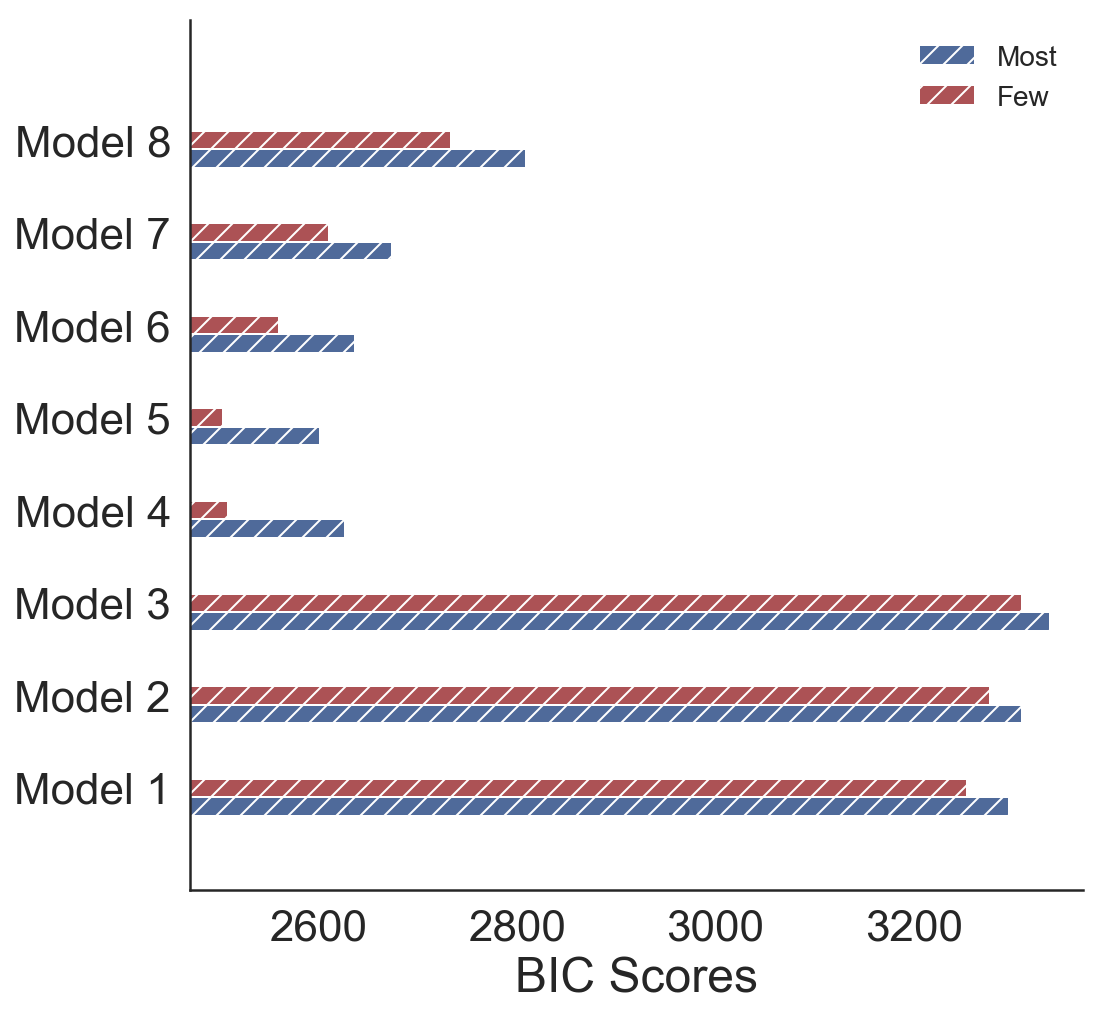

In [35]:
# Plot both conditions
BIC_bar2(Choice_Table_like.loc[1:, :].copy().reset_index(drop=True),Choice_Table_dislike.loc[1:, :].copy().reset_index(drop=True), title='',color1 ='#4F6A9A',color2 ='#AC5255' )

plt.savefig('SavedFigures/ModelComparison_Choice_More_Less_GlamEx_m2.svg', format='svg', dpi = 500)

## Model 5 seems to be the best in both cases

------------------------------------------------------
------------------------------------------------------
# Confidence Models
-------------------------------------------------------
-------------------------------------------------------

In [36]:
confidence_models = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5']
confidence_formulas = ['Confidence ~ |Difference in Value|', 'Confidence ~ |Difference in Value| + Response Time',
                  'Confidence ~ |Difference in Value| + Response Time + Gaze Shift Frequency',
                  'Confidence ~ |Difference in Value| + Response Time + Gaze Shift Frequency + Total Value',
                      'Confidence ~ |Difference in Value| + Response Time + Gaze Shift Frequency + Total Value + Difference in Dwell Time']
Confidence_1_Table = pd.DataFrame([confidence_models, confidence_formulas])
Confidence_1_Table = Confidence_1_Table.transpose(); Confidence_1_Table.columns = ['Models', 'Formulas']
Confidence_Table_like = Confidence_1_Table.copy()
Confidence_Table_dislike = Confidence_1_Table.copy()
Confidence_1_Table

,Models,Formulas
0,Model 1,Confidence ~ |Difference in Value|
1,Model 2,Confidence ~ |Difference in Value| + Response Time
2,Model 3,Confidence ~ |Difference in Value| + Response Time + Gaze Shift Frequency
3,Model 4,Confidence ~ |Difference in Value| + Response Time + Gaze Shift Frequency + Total Value
4,Model 5,Confidence ~ |Difference in Value| + Response Time + Gaze Shift Frequency + Total Value + Difference in Dwell Time


## Models for More frame
---------------------------------------------------

we test various nested models

In [37]:
%%R

if (file.exists('SavedModels/ComparisonModels_Confidence_More_GlamEx_m2.rda')){
    load('SavedModels/ComparisonModels_Confidence_More_GlamEx_m2.rda')   
    print('  Found old parameter estimates in "SavedModels/estimates". Skipping estimation...')
}

else{

confidence_model_1L = lmer(zConf ~ 0 + zAbsDVal + (0 + zAbsDVal | Part), data=data_exp1_Like,
                       control=lmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))

confidence_model_2L = lmer(zConf ~ 0 + zAbsDVal + zRT + (0 + zAbsDVal + zRT | Part), data=data_exp1_Like,
                       control=lmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))

confidence_model_3L = lmer(zConf ~ 0 + zAbsDVal + zRT + zGSF + (0 + zAbsDVal
                         + zGSF + zRT | Part), data=data_exp1_Like,
                       control=lmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
print ("Done!")


confidence_model_4L = lmer(zConf ~ 0 + zAbsDVal + zRT + zGSF + zTotVal + (0 + zAbsDVal
                         + zGSF + zRT + zTotVal | Part), data=data_exp1_Like,
                       control=lmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))

confidence_model_5L = lmer(zConf ~ 0 + zAbsDVal + zRT + zGSF + zTotVal + zAbsDDT + (0 + zAbsDVal
                         + zGSF + zRT + zTotVal + zAbsDDT| Part), data=data_exp1_Like,
                       control=lmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
print ("Done!")

save(confidence_model_1L, confidence_model_2L, confidence_model_3L,
                    confidence_model_4L, confidence_model_5L, file = "SavedModels/ComparisonModels_Confidence_More_GlamEx_m2.rda")
    
}

[1] "Done!"
[1] "Done!"


## Model comparison¶


In [38]:
%%R
comparison_confidence_L =anova(confidence_model_1L, confidence_model_2L, confidence_model_3L,
                    confidence_model_4L, confidence_model_5L)
BIC1_confidence_L = list(comparison_confidence_L$BIC)

In [39]:
%%R
comparison_confidence_L

Data: data_exp1_Like
Models:
confidence_model_1L: zConf ~ 0 + zAbsDVal + (0 + zAbsDVal | Part)
confidence_model_2L: zConf ~ 0 + zAbsDVal + zRT + (0 + zAbsDVal + zRT | Part)
confidence_model_3L: zConf ~ 0 + zAbsDVal + zRT + zGSF + (0 + zAbsDVal + zGSF + zRT | 
confidence_model_3L:     Part)
confidence_model_4L: zConf ~ 0 + zAbsDVal + zRT + zGSF + zTotVal + (0 + zAbsDVal + 
confidence_model_4L:     zGSF + zRT + zTotVal | Part)
confidence_model_5L: zConf ~ 0 + zAbsDVal + zRT + zGSF + zTotVal + zAbsDDT + (0 + 
confidence_model_5L:     zAbsDVal + zGSF + zRT + zTotVal + zAbsDDT | Part)
                    Df    AIC    BIC  logLik deviance    Chisq Chi Df
confidence_model_1L  3 9176.7 9195.1 -4585.4   9170.7                
confidence_model_2L  6 8757.6 8794.3 -4372.8   8745.6 425.1117      3
confidence_model_3L 10 8681.7 8742.9 -4330.8   8661.7  83.9453      4
confidence_model_4L 15 8685.6 8777.4 -4327.8   8655.6   6.1142      5
confidence_model_5L 21 8650.0 8778.5 -4304.0   8608.0  47.5404 

In [40]:
%R -o BIC1_confidence_L
BIC1a = np.array(BIC1_confidence_L); BIC1a = BIC1a[0]

In [41]:
Confidence_Table_like['BIC'] = BIC1a


## Models for Less frame
---------------------------------------------------------
we test various nested models

In [42]:
%%R

if (file.exists('SavedModels/ComparisonModels_Confidence_Less_GlamEx_m2.rda')){
    load('SavedModels/ComparisonModels_Confidence_Less_GlamEx_m2.rda')   
    print('  Found old parameter estimates in "SavedModels/estimates". Skipping estimation...')
}

else{
confidence_model_1D = lmer(zConf ~ 0 + zAbsDVal + (0 + zAbsDVal | Part), data=data_exp1_DisLike,
                       control=lmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))

confidence_model_2D = lmer(zConf ~ 0 + zAbsDVal + zRT + (0 + zAbsDVal + zRT | Part), data=data_exp1_DisLike,
                       control=lmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))

confidence_model_3D = lmer(zConf ~ 0 + zAbsDVal + zRT + zGSF + (0 + zAbsDVal
                         + zGSF + zRT | Part), data=data_exp1_DisLike,
                       control=lmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
print ("Done!")
    
confidence_model_4D = lmer(zConf ~ 0 + zAbsDVal + zRT + zGSF + zTotVal + (0 + zAbsDVal
                         + zGSF + zRT + zTotVal | Part), data=data_exp1_DisLike,
                       control=lmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))

confidence_model_5D = lmer(zConf ~ 0 + zAbsDVal + zRT + zGSF + zTotVal + zAbsDDT + (0 + zAbsDVal
                         + zGSF + zRT + zTotVal + zAbsDDT| Part), data=data_exp1_DisLike,
                       control=lmerControl(optimizer="optimx", optCtrl=list(method="nlminb")))
print ("Done!")
    
save(confidence_model_1D, confidence_model_2D, confidence_model_3D,
                    confidence_model_4D, confidence_model_5D, file = "SavedModels/ComparisonModels_Confidence_Less_GlamEx_m2.rda")
    
}

[1] "Done!"
[1] "Done!"


## Model comparison¶


In [43]:
%%R
comparison_confidence_D =anova(confidence_model_1D, confidence_model_2D, confidence_model_3D,
                    confidence_model_4D, confidence_model_5D)
BIC1_confidence_D = list(comparison_confidence_D$BIC)

In [44]:
%%R
comparison_confidence_D

Data: data_exp1_DisLike
Models:
confidence_model_1D: zConf ~ 0 + zAbsDVal + (0 + zAbsDVal | Part)
confidence_model_2D: zConf ~ 0 + zAbsDVal + zRT + (0 + zAbsDVal + zRT | Part)
confidence_model_3D: zConf ~ 0 + zAbsDVal + zRT + zGSF + (0 + zAbsDVal + zGSF + zRT | 
confidence_model_3D:     Part)
confidence_model_4D: zConf ~ 0 + zAbsDVal + zRT + zGSF + zTotVal + (0 + zAbsDVal + 
confidence_model_4D:     zGSF + zRT + zTotVal | Part)
confidence_model_5D: zConf ~ 0 + zAbsDVal + zRT + zGSF + zTotVal + zAbsDDT + (0 + 
confidence_model_5D:     zAbsDVal + zGSF + zRT + zTotVal + zAbsDDT | Part)
                    Df    AIC    BIC  logLik deviance   Chisq Chi Df Pr(>Chisq)
confidence_model_1D  3 9756.0 9774.4 -4875.0   9750.0                          
confidence_model_2D  6 9342.1 9378.8 -4665.0   9330.1 419.901      3  < 2.2e-16
confidence_model_3D 10 9305.6 9366.8 -4642.8   9285.6  44.501      4  5.049e-09
confidence_model_4D 15 9223.4 9315.2 -4596.7   9193.4  92.235      5  < 2.2e-16
confidence

In [45]:
%R -o BIC1_confidence_D
BIC1a = np.array(BIC1_confidence_D); BIC1a = BIC1a[0]

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


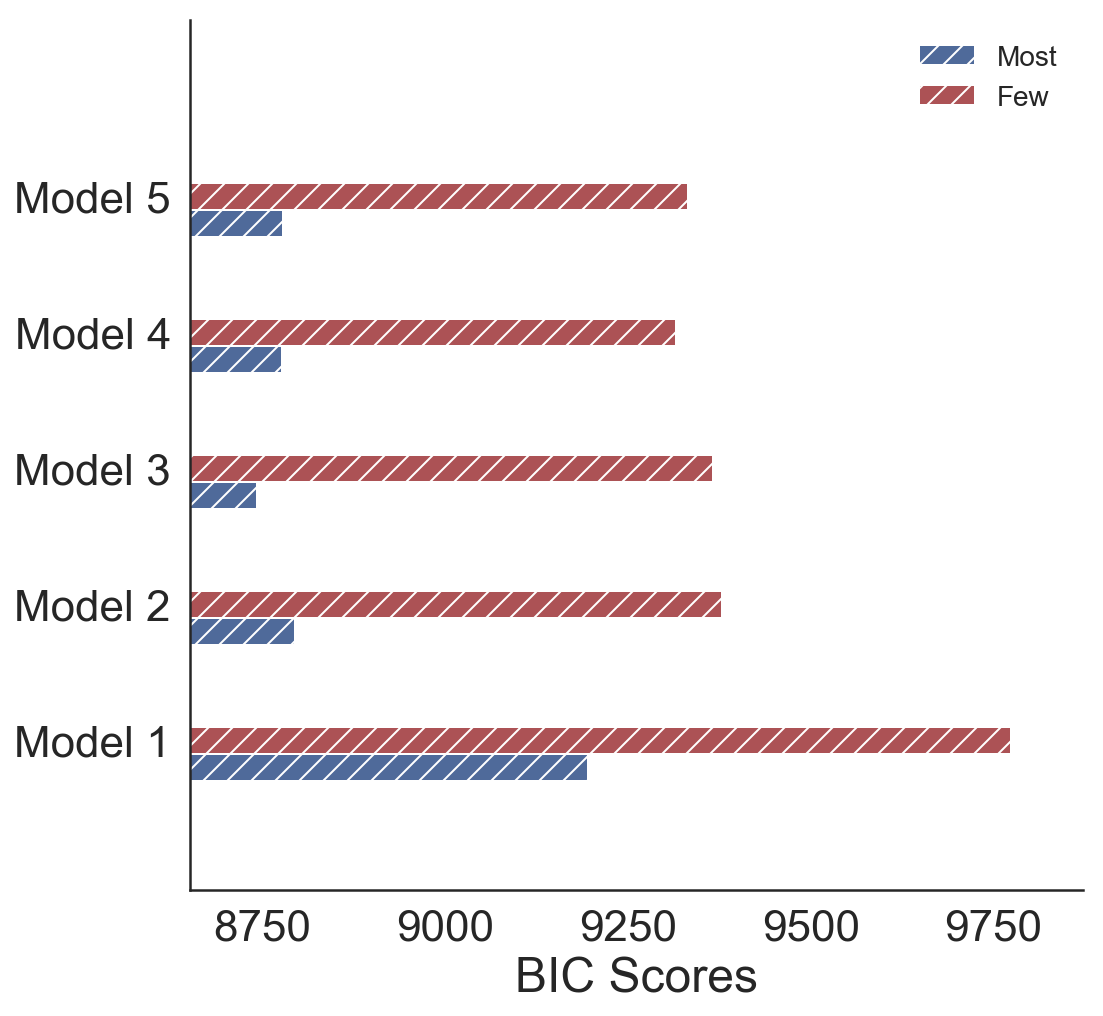

In [46]:
Confidence_Table_dislike['BIC'] = BIC1a
#BIC_bar(Confidence_Table_dislike.loc[0:, :].copy().reset_index(drop=True), title='',color1 = '#4F6A9A' )

BIC_bar2(Confidence_Table_like.loc[0:, :].copy().reset_index(drop=True),Confidence_Table_dislike.loc[0:, :].copy().reset_index(drop=True), title='',color1 ='#4F6A9A',color2 ='#AC5255' )
#plt.tight_layout()
#plt.savefig('../../figures/exp1_choice_models.png', dpi=600)
plt.savefig('SavedFigures/ModelComparison_Confidence_More_Less_GlamEx_m2.svg', format='svg', dpi = 500)

## Model 3 is best for MORE and Model 4 is better for LESS 


# 1. Import Packages

In [2]:
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame as DF

import seaborn as sns
sns.set(color_codes=True)
#np.random.seed(sum(map(ord, "distributions")))
from sklearn import linear_model  # packages for the logistic regression function to plot the logistic regression 
from sklearn.linear_model import LogisticRegression # packages for the logistic regression function to plot the logistic regression 
import scipy
from scipy import stats, integrate
from scipy.stats import mode
from scipy.stats.stats import pearsonr # Pearson's correlation
from copy import copy as copy
import operator as operator
import pylab

# Plotting tools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%pylab inline
figsize(5, 5)

import glob

import os
# Added to avoid OMP:error#15
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Populating the interactive namespace from numpy and matplotlib


/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy', 'pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
import rpy2

%load_ext rpy2.ipython
# Set up interface with R
# Make it easy to set and find values in a multi-index DF
idx = pd.IndexSlice
# Set up interface with R
%config InlineBackend.figure_format = 'retina'
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)


In [4]:
%%R
library(lme4)
#library(car)
library(optimx)
library(ggplot2)
library(MASS)
library(broom)
library(dplyr)
library(reshape2)
library(arm)
library(multcomp)
library(pbkrtest)

<a id='LoadFunc'></a>
# 2. Defining Functions

### Split variable into participantwise quantiles

In [5]:
def parsplit(DF, input, quantiles):
    qvalues = pd.qcut(DF[input], quantiles, labels = range(1, quantiles+1))
    return qvalues

### Regression Coefficients Plot

In [6]:
def Coefpresplot_bar(regtable, mixtable, intercept=False, barcol='#000000', title='Regression Coefficients', size='big', ylimits=(), ymultiple=0.5, ticklabsize=25, n_ET_predictors = 0 ):

    # Import itertools so that we can iterate through the colours
    import itertools
    
    # Import locators so that we can tidy up the yaxis
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    
    # rounding function to get edges to even 0.5 values
    def round_to(n, precision):
        correction = 0.5 if n >= 0 else -0.5
        return int( n/precision+correction ) * precision

    def round_to_5(n):
        return round_to(n, 0.5)
            
    # Set seaborn style for the plot
    sns.set(style='white')
    
    # Generate the figure
    if size=='big':
        fig = plt.figure(figsize=[20,8])
    elif size=='long':
        fig = plt.figure(figsize=[20,4])
    elif size=='narrow':
        fig = plt.figure(figsize=[10,4])
        
    fig.suptitle(title, fontsize=20)
    gs = GridSpec(1,1,bottom=0.18,left=0.18,right=0.82)
    ax = fig.add_subplot(gs[0,0])
    
    # Set axis limits based on whether to include the intercept or not    
    if intercept == True:
        XLim = (0, len(regtable.columns) + 1)
        YLim = (round_to_5(np.min(mixtable)-0.2), round_to_5(np.max(mixtable)+0.2))
    else:
        XLim = (0, len(regtable.columns) )
        YLim = (round_to_5(np.min(mixtable)-0.2), round_to_5(np.max(mixtable)+0.2))
    if ylimits != ():
        YLim = ylimits
    ax.set_xlim(XLim)
    ax.set_ylim(YLim)
    
    # Draw a line through the 0-value on the y-axis
    line = ax.plot(XLim, [0, 0], color='black', ls='--', alpha = 0.5, lw=3)
    
    
    # If intercept is true, plot the coefficient for the intercept
    if intercept == True:
        Coefficients = regtable.columns
    else:
        Coefficients = regtable.columns[1:]
        
    # Determine the colours for the coefficients based on the n_ET_variable
    n_predictors = len(Coefficients)
    n_non_ET_predictors = n_predictors - n_ET_predictors
    
    colourlist = [barcol] * n_non_ET_predictors + ['#03719c'] * n_ET_predictors
    
        
    # Plot all the coefficients with 95% CI
    position = 0
    for Coefficient in Coefficients:
        position += 1
        ax.bar(position, regtable.loc['coefficient', Coefficient], width=0.8,color=colourlist[position-1],)
        ax.errorbar(position, regtable.loc['coefficient', Coefficient],
                    yerr=regtable.loc['se', Coefficient]*1.96, lw=2, color='#000000')
        
   # Plot dots for the individual coefficients
    coef_num = len(mixtable)
    for i in range(1,coef_num):
        part_coefs = mixtable[i]
        position_parts= np.full(len(part_coefs), i, dtype=int)
        jittr = np.random.uniform(low=-0.5,high=0.5,size=len(part_coefs))/2
        ax.plot(position_parts+jittr, part_coefs, marker='o', ms=8, color='#000000',alpha=0.3,linestyle="None")

        

    # Setting the x-axis major tick's location
    ax.set_xticks(range(1, position+1))
    
    # set the y-axis major tick position
    ax.yaxis.set_major_locator(MultipleLocator(ymultiple))


    # Setting the x-axis major tick's label
    if intercept == True:
        ax.set_xticklabels(regtable.columns, rotation=40)
    else: 
        ax.set_xticklabels(regtable.columns[1:], rotation=40)
    
    ax.tick_params(axis='both', which='major', labelsize=ticklabsize)
    ax.set_ylabel('Regression Coefficients', fontsize=18)
    
    # Autoformats the ticklabels for the xaxis
    fig.autofmt_xdate()
    
    sns.despine()

In [7]:
def Coefpresplot_bar2(regtable1, mixtable1,regtable2, mixtable2, intercept=False, barcol1='#000000',barcol2='#000000', title='Regression Coefficients', size='big', ylimits=(), ymultiple=0.5, ticklabsize=25, n_ET_predictors = 0 ):

    # Import itertools so that we can iterate through the colours
    import itertools
    
    # Import locators so that we can tidy up the yaxis
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter
    
    # rounding function to get edges to even 0.5 values
    def round_to(n, precision):
        correction = 0.5 if n >= 0 else -0.5
        return int( n/precision+correction ) * precision

    def round_to_5(n):
        return round_to(n, 0.5)
            
    # Set seaborn style for the plot
    sns.set(style='white')
    
    # Generate the figure
    if size=='big':
        fig = plt.figure(figsize=[20,8])
    elif size=='long':
        fig = plt.figure(figsize=[20,4])
    elif size=='narrow':
        fig = plt.figure(figsize=[10,4])
        
    fig.suptitle(title, fontsize=20)
    gs = GridSpec(1,1,bottom=0.18,left=0.18,right=0.82)
    ax = fig.add_subplot(gs[0,0])
    
    # Set axis limits based on whether to include the intercept or not   
    # Assumuing that regtable1 and regtable2 have exactly the same number of coefficients
    if intercept == True:
        XLim = (0, len(regtable1.columns) + 2)
        YLim = (round_to_5(np.min([mixtable1,mixtable2]))-0.2, round_to_5(np.max([mixtable1,mixtable2]))+0.2)
    else:
        XLim = (0, len(regtable1.columns) +1)
        YLim = (round_to_5(np.min([mixtable1,mixtable2]))-0.2, round_to_5(np.max([mixtable1,mixtable2]))+0.2)
    if ylimits != ():
        YLim = ylimits
    ax.set_xlim(XLim)
    ax.set_ylim(YLim)
    
    # Draw a line through the 0-value on the y-axis
    line = ax.plot(XLim, [0, 0], color='black', ls='--', alpha = 0.5, lw=3)
    
    
    # If intercept is true, plot the coefficient for the intercept
    # Assumuing that regtable1 and regtable2 have exactly the same number of coefficients

    if intercept == True:
        Coefficients = regtable1.columns
    else:
        if len(regtable1.columns)<len(mixtable1):
            Coefficients = regtable1.columns
        else:
            Coefficients = regtable1.columns[1:]
        
    # Determine the colours for the coefficients based on the n_ET_variable
    n_predictors = len(Coefficients)
    n_non_ET_predictors = n_predictors - n_ET_predictors
    
    # Color for conditions 1 and 2
    colourlist1 = [barcol1] * n_non_ET_predictors + ['#03719c'] * n_ET_predictors
    colourlist2 = [barcol2] * n_non_ET_predictors + ['#03719c'] * n_ET_predictors
    
        
    # Plot all the coefficients with 95% CI
    position = 0
    for Coefficient in Coefficients:
        position += 1
        # Plot condition 1
        ax.bar(position-0.2, regtable1.loc['coefficient', Coefficient], width=0.4,color=colourlist1[position-1],)
        ax.errorbar(position-0.2, regtable1.loc['coefficient', Coefficient],
                    yerr=regtable1.loc['se', Coefficient]*1.96, lw=2, color='#000000')

        # Plot condition 2
        ax.bar(position+0.2, regtable2.loc['coefficient', Coefficient], width=0.4,color=colourlist2[position-1],)
        ax.errorbar(position+0.2, regtable2.loc['coefficient', Coefficient],
                    yerr=regtable2.loc['se', Coefficient]*1.96, lw=2, color='#000000')

        
   # Plot dots for the individual coefficients
    # Assumuing that mixtable1 and mixtable2 have exactly the same number of elements 
    
    if intercept == True:
        coef_num = range(0,len(mixtable1)) 
    else:
        coef_num = range(1,len(mixtable1))
        
    for i in coef_num:
        # Plot dots condition 1
        part_coefs = mixtable1[i]
        position_parts= np.full(len(part_coefs), i, dtype=int)
        jittr = np.random.uniform(low=-0.2,high=0.2,size=len(part_coefs))/2
        ax.plot(position_parts-0.2+jittr, part_coefs, marker='o', ms=8, color='#000000',alpha=0.3,linestyle="None")

        # Plot dots condition 1
        part_coefs = mixtable2[i]
        position_parts= np.full(len(part_coefs), i, dtype=int)
        jittr = np.random.uniform(low=-0.2,high=0.2,size=len(part_coefs))/2
        ax.plot(position_parts+0.2+jittr, part_coefs, marker='o', ms=8, color='#000000',alpha=0.3,linestyle="None")
        

    # Setting the x-axis major tick's location
    ax.set_xticks(range(1, position+1))
    
    # set the y-axis major tick position
    ax.yaxis.set_major_locator(MultipleLocator(ymultiple))


    # Setting the x-axis major tick's label
    if intercept == True:
        ax.set_xticklabels(regtable1.columns, rotation=40)        
    else:
        if len(regtable1.columns)<len(mixtable1):
            ax.set_xticklabels(regtable1.columns, rotation=40)
        else:    
            ax.set_xticklabels(regtable1.columns[1:], rotation=40)
    
    ax.tick_params(axis='both', which='major', labelsize=ticklabsize)
    ax.set_ylabel('Regression Coefficients', fontsize=18)
    
    # Autoformats the ticklabels for the xaxis
    fig.autofmt_xdate()
    
    sns.despine()

In [8]:
def regtable(fix, fix_se, names):
    fixed_betas = DF(np.array(fix)); fixed_betas = fixed_betas.transpose(); fixed_betas.columns = names
    fixed_betas.loc[1] = np.array(fix_se)
    fixed_betas.loc[2] = fixed_betas.loc[0] - (fixed_betas.loc[1]*1.96)
    fixed_betas.loc[3] = fixed_betas.loc[0] + (fixed_betas.loc[1]*1.96)
    fixed_betas.index = ['coefficient', 'se', 'CImin', 'CImax']
    return fixed_betas

In [9]:
def correl_plot2 (data_all,data_all2,x_variable,y_variable,color1 = '#000000',color2 = '#000000',x_varlabel = "x_variable" ,y_varlabel = "y_variable", data_label =('Correct', 'Error'), title = "Pretty PLot"):

    f = plt.figure(figsize=(8, 8))
    sns.set(style='white', font_scale=1.8)
    ax = sns.regplot(data=data_all, x= x_variable, y=y_variable, fit_reg=False, ci=0, color= color1, scatter_kws={'s':70,'alpha':0.3},)
    ax = sns.regplot(data=data_all2, x= x_variable, y=y_variable, fit_reg=False, ci=0, color= color2, scatter_kws={'s':70,'alpha':0.3})
    ax.set(ylabel=y_varlabel, xlabel=x_varlabel)

    # For data 1
    x=data_all[x_variable]
    y=data_all[y_variable]
    fit = np.polyfit(x, y, deg=1)
    future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    p1 = ax.plot(future, future_fit, color=color1, lw=3, label = data_label[0])
    
    results = pearsonr(data_all[x_variable], data_all[y_variable])
    print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))
    
    # For data 2
    x=data_all2[x_variable]
    y=data_all2[y_variable]
    fit = np.polyfit(x, y, deg=1)
    future = np.arange(min(x)-0.2, max(x)+0.2, 0.01)
    fit_fn = np.poly1d(fit)
    future_fit = np.polyval(fit_fn, future)
    p2 = ax.plot(future, future_fit, color=color2, lw=3,label = data_label[1] )
    sns.despine()
    #ax.set_title(title)    
    results = pearsonr(data_all2[x_variable], data_all2[y_variable])
    print ("Pearson's r = {0}".format(np.round(results[0], 3)), "p = ", np.round(results[1], 3))
    
    ax.legend()
    ax.set_title(title)

    #plt.legend((p1, p2), data_label )
    
    plt.show()

In [10]:
def BIC_bar(data, title='title',color1 ='#5b7c99' ):
    
    # set figure-level properties
    sns.set(font_scale=2, style='white')
    fig = figure(figsize=(8,8))
    fig.add_subplot(111)
    top= subplot(111)
    
    # determine variables
    BIC = data['BIC'].get_values()
    N = len(data['BIC'])
    ylims = [data['BIC'].min()-(data['BIC'].max()/100), data['BIC'].max()+(data['BIC'].max()/100)]
    ind = np.arange(N)  # the x locations for the groups
    width = 0.5      # the width of the bars

    # draw the bars
    rects1 = top.barh(ind, BIC, width, color=color1)

    # add some text for labels, title and axes ticks
    top.set_xlabel('BIC Scores')
    top.set_title(title)
    top.set_yticks(ind+width/2)
    top.set_yticklabels(data['Models'], rotation='horizontal')
    
    # set the axis limits
    top.set_xlim(ylims)
    top.set_ylim([-0.5, N])
    
    # hide spines
    top.spines['top'].set_visible(False)
    top.spines['right'].set_visible(False)

In [11]:
def BIC_bar2(data1,data2, title='title',color1 ='#5b7c99',color2 ='#AC5255' ):
    
    #Assuming data 1 and data2 contain the same dimensions
    # set figure-level properties
    sns.set(font_scale=2, style='white')
    fig = figure(figsize=(8,8))
    fig.add_subplot(111)
    top= subplot(111)
    
    # determine variables
    BIC1= data1['BIC'].get_values()
    BIC2 = data2['BIC'].get_values()
    N = len(data1['BIC'])
    ylims = [min(data1['BIC'].min()-(data1['BIC'].max()/100), data2['BIC'].min()-(data2['BIC'].max()/100)), max(data1['BIC'].max()+(data1['BIC'].max()/100),data2['BIC'].max()+(data2['BIC'].max()/100))]
    ind = np.arange(N)  # the x locations for the groups
    width = 0.2      # the width of the bars

    # draw the bars
    rects1 = top.barh(ind-0.1, BIC1, width, color=color1,hatch='//')
    rects2 = top.barh(ind+0.1, BIC2, width, color=color2,hatch='//')

    # add some text for labels, title and axes ticks
    top.set_xlabel('BIC Scores')
    top.set_title(title)
    top.set_yticks(ind+width/2)
    top.set_yticklabels(data1['Models'], rotation='horizontal')
    
    # set the axis limits
    top.set_xlim(ylims)
    top.set_ylim([-1, N+0.4])
    
    # hide spines
    top.spines['top'].set_visible(False)
    top.spines['right'].set_visible(False)
    
    patch1 = mpatches.Patch(facecolor=color1,hatch=r'//', label='Most')
    patch2 = mpatches.Patch(facecolor=color2,hatch=r'//', label='Few')

    leg = plt.legend(handles=[patch1,patch2],fontsize=14)
    leg.get_frame().set_facecolor('none')
    leg.get_frame().set_linewidth(0.0)

In [12]:
def z_score1(data_all, part_def,z_score_var):
    z_matrix=[]
    z_matrix_aux=[]

    for i in (data_all[part_def].unique()):
        Choicedata = data_all.loc[data_all[part_def] == i]    
    
        pX_A= pd.to_numeric(Choicedata[z_score_var]) 
        pX_zA= (pX_A - np.mean(pX_A))/np.std(pX_A)

        z_matrix_aux= pX_zA.values
    
        for  j in range(len(z_matrix_aux)):    
            z_matrix.append(z_matrix_aux[j])
    return z_matrix

In [13]:
def splitBy(data_exp1, Splits_headers = ['ConfSplit', 'GSFMedSplit','DDTMedSplit'],Splits_variables = ['Conf', 'tGSF','tDDT']):
    
    median_matrix=[]
    median_matrix_aux=[]
    median_matrix_aux_cond=[]
    Split_cols = []
    
    for h in range(len(Splits_variables)):
        median_matrix=[]
        for i in unique(data_exp1["Part"]):
            median_matrix_aux=[]
    
            for j in unique(data_exp1["BlockCond"]):
                #median_matrix_aux_cond=[]
    
                #Extract data by participant and BlockCond (1: MORE, 2: LESS)
                Splitdata = data_exp1.loc[data_exp1['Part'] == i]
                Splitdata = Splitdata.loc[Splitdata['BlockCond'] == j]
                
                # Select the column to split
                Splitdata = Splitdata.loc[:,['TrialN',Splits_variables[h]]]
                SplitSort = Splitdata.values
                # Sort for confidence column
                SplitSort = SplitSort[np.argsort(SplitSort[:, 1])]
                #print(SplitSort)
                lenPart = len(Splitdata)
                #print(lenPart)
                # Generate column with median order
                median_low = [0] * int (lenPart/2)
    
                if len(SplitSort) != 2*len(median_low):
                    median_high=  [1] * int(len(SplitSort)-len(median_low))
                else: median_high = [1] * int (lenPart/2)
            
                median_split_order = median_low + median_high
                #Attach split median order column (1 and 0)
                median_aux= np.column_stack((SplitSort,median_split_order))
                #Sort back to trial number
                SplitSorted = median_aux[np.argsort(median_aux[:, 0])]
                #print(len(SplitSorted))
                
                for kk in range(len(SplitSorted)): 
                    if len(median_matrix_aux) == 0 :
                        median_matrix_aux = SplitSorted[0]
                    else:
                        median_matrix_aux = np.vstack([median_matrix_aux, SplitSorted[kk]])
            
            
            #print(["participant "+ str(i)+ " done"])
            # sort after adding both conditions    
            median_matrix_aux = median_matrix_aux[np.argsort(median_matrix_aux[:, 0])]
            
            #Extract only the column with the median split information
            median_matrix_aux = median_matrix_aux[:,2]
            
            #append to median matrix for the participants
            for k in range(len(median_matrix_aux)):    
                median_matrix.append(median_matrix_aux [k])
        
        median_matrix = pd.DataFrame(median_matrix,columns=[Splits_headers[h]])
        #print(len (median_matrix))
        #add new column (new split variable columns) to the split matrix
        if  h == 0:
            Split_cols = median_matrix
        else:
            Split_cols = pd.concat([Split_cols,median_matrix ],axis =1)   
    
    return Split_cols